In [1]:
import tensorflow as tf

In [2]:
# list tf devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import random
from data_loader import load_images_and_labels
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import sys
import gc

def mem_check():
    def get_size(obj):
        return sys.getsizeof(obj)

    variables = globals()

    sorted_vars = sorted(
        variables.items(), key=lambda item: get_size(item[1]), reverse=True
    )

    total_memory = 0
    for var_name, var_value in sorted_vars[:10]:
        size = get_size(var_value)
        total_memory += size
        print(f"{var_name}: {size / (1024 ** 2):.2f} MB")

    print(f"Total memory usage: {total_memory / (1024 ** 2):.2f} MB")

# Preprocessing and Feature Engineering Data

In [5]:
directory = "caltech-101/101_ObjectCategories"
img_height = 128
img_width = 128

exclude_classes = {"airplanes", "Motorbikes", "Faces", "Faces_easy", "watch", "Leopards"}
images, labels, class_names = load_images_and_labels(directory, img_height, img_width, exclude_classes)

In [6]:
mem_check()

images: 1081.88 MB
labels: 0.02 MB
class_names: 0.00 MB
_ii: 0.00 MB
_i4: 0.00 MB
exclude_classes: 0.00 MB
_i: 0.00 MB
_i5: 0.00 MB
_oh: 0.00 MB
Out: 0.00 MB
Total memory usage: 1081.90 MB


In [7]:
class_names

['accordion',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'schooner',
 'scissors',
 'scorpion',
 'sea_horse',
 'snoopy',
 'socce

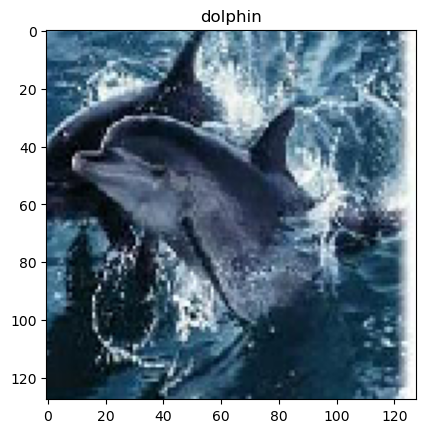

In [8]:
# show a random image
index = random.randint(0, len(images))
plt.imshow(images[index] / 255.0)
plt.title(class_names[labels[index]])
plt.show()

# Data Augmentation

As seen in [exploratory_data_analysis.ipynb](exploratory_data_analysis.ipynb), each class has a different number of images. This will cause bias in our model towards certain classes. We need to fix this by generating more images for the classes that are under represented.

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

unique_classes, class_counts = np.unique(labels, return_counts=True)
max_count = np.max(class_counts)

balanced_images = []
balanced_labels = []

for class_id in unique_classes:
    print("Balancing class", class_names[class_id])
    # get all images and labels of the current class
    class_images = images[labels == class_id]
    class_labels = labels[labels == class_id]
    
    # add the ones we already have to the balanced dataset
    balanced_images.extend(class_images)
    balanced_labels.extend(class_labels)
    
    num_to_generate = max_count - len(class_images)
    
    if num_to_generate > 0:
        augmented_images = []
        augmented_labels = []
        # generate new images
        for x_batch, y_batch in datagen.flow(class_images, class_labels, batch_size=num_to_generate):
            augmented_images.extend(x_batch)
            augmented_labels.extend(y_batch)
            if len(augmented_images) >= num_to_generate:
                break
        
        # add generated images to balanced dataset
        balanced_images.extend(augmented_images[:num_to_generate])
        balanced_labels.extend(augmented_labels[:num_to_generate])

balanced_images = np.array(balanced_images, dtype=np.float16)
balanced_labels = np.array(balanced_labels)
balanced_images = balanced_images / 255.0 # normalize

del class_images
del class_labels
del augmented_images
del augmented_labels
del x_batch
del y_batch
del images 
del labels
gc.collect()

Balancing class accordion
Balancing class anchor
Balancing class ant
Balancing class barrel
Balancing class bass
Balancing class beaver
Balancing class binocular
Balancing class bonsai
Balancing class brain
Balancing class brontosaurus
Balancing class buddha
Balancing class butterfly
Balancing class camera
Balancing class cannon
Balancing class car_side
Balancing class ceiling_fan
Balancing class cellphone
Balancing class chair
Balancing class chandelier
Balancing class cougar_body
Balancing class cougar_face
Balancing class crab
Balancing class crayfish
Balancing class crocodile
Balancing class crocodile_head
Balancing class cup
Balancing class dalmatian
Balancing class dollar_bill
Balancing class dolphin
Balancing class dragonfly
Balancing class electric_guitar
Balancing class elephant
Balancing class emu
Balancing class euphonium
Balancing class ewer
Balancing class ferry
Balancing class flamingo
Balancing class flamingo_head
Balancing class garfield
Balancing class gerenuk
Balancin

3529

In [10]:
mem_check()

balanced_images: 1140.00 MB
balanced_labels: 0.05 MB
_i: 0.00 MB
_i9: 0.00 MB
class_counts: 0.00 MB
__: 0.00 MB
class_names: 0.00 MB
_7: 0.00 MB
_i4: 0.00 MB
unique_classes: 0.00 MB
Total memory usage: 1140.05 MB


In [11]:
x_train, x_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, stratify=balanced_labels, random_state=123)

del balanced_images
del balanced_labels

print("Class Names:", class_names)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Class Names: ['accordion', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler', 'starfish', 'stegosaurus', 'stop_sign', 'straw

In [12]:
mem_check()

x_train: 912.00 MB
x_test: 228.00 MB
y_train: 0.04 MB
y_test: 0.01 MB
_iii: 0.00 MB
_i9: 0.00 MB
class_counts: 0.00 MB
__: 0.00 MB
class_names: 0.00 MB
_7: 0.00 MB
Total memory usage: 1140.05 MB


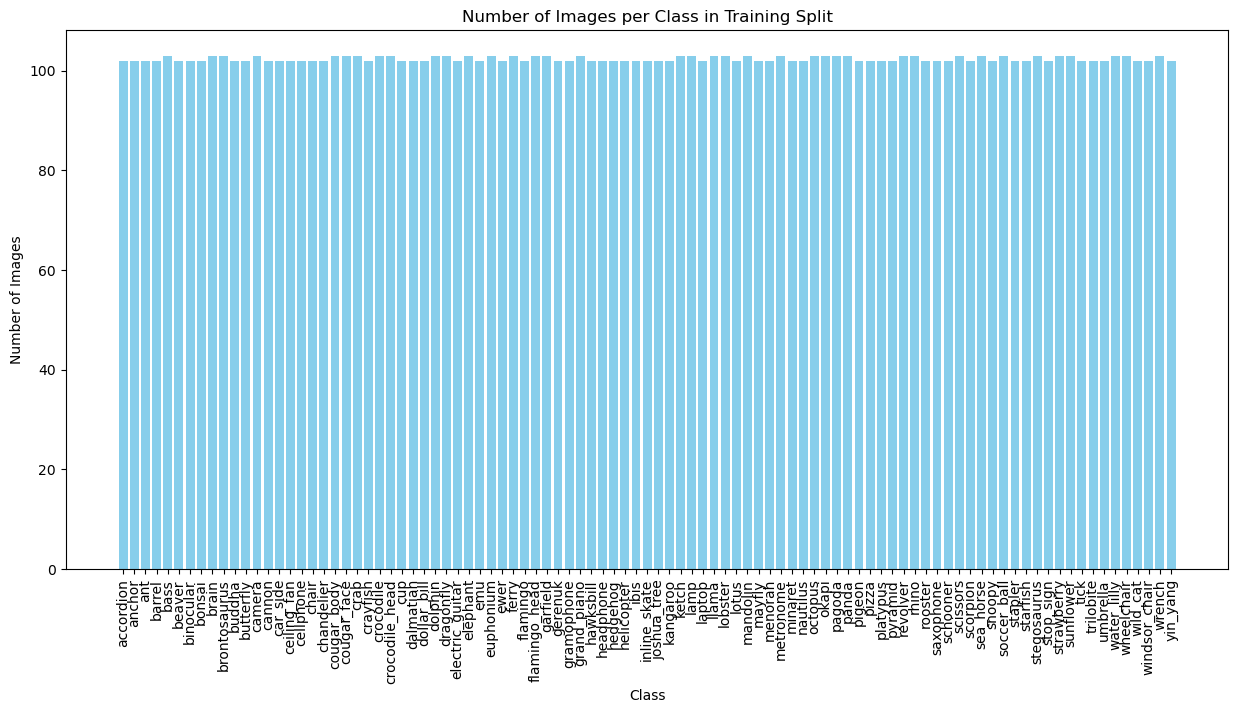

In [13]:
# show number of images per class in the training split - you can see that the dataset is now balanced
plt.figure(figsize=(15, 7))
plt.bar(class_names, np.bincount(y_train), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Split')
plt.show()

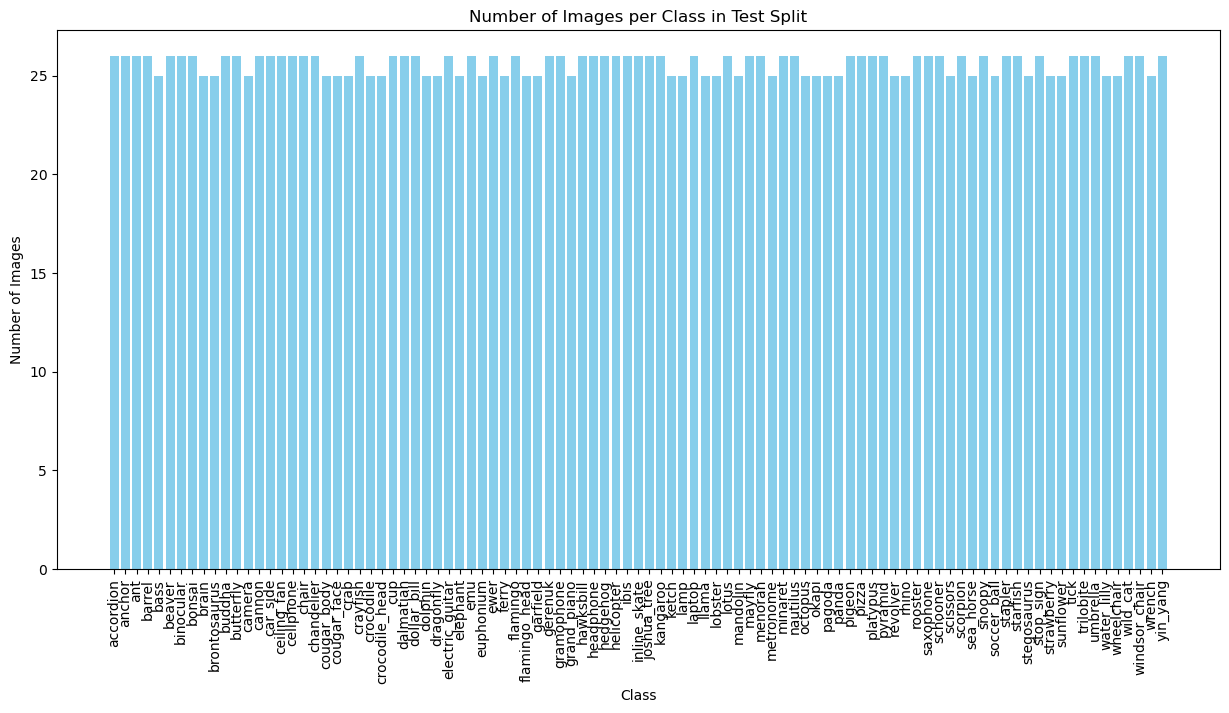

In [14]:
# show number of images per class in the test split - you can see that the dataset is now balanced
plt.figure(figsize=(15, 7))
plt.bar(class_names, np.bincount(y_test), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Test Split')
plt.show()

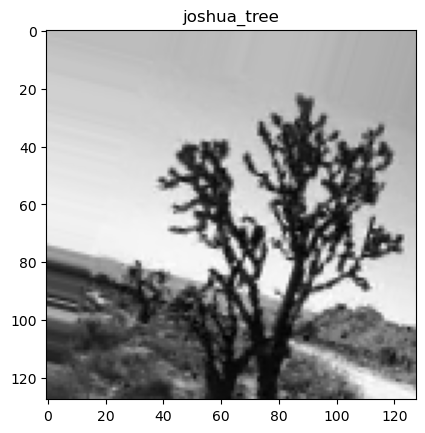

In [15]:
# shows a random augmented image
index = random.randint(0, len(x_train))
plt.imshow(x_train[index].astype(np.float32))
plt.title(class_names[y_train[index]])
plt.show()

# CNN Model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 512)               65028608  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [17]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="max",
    restore_best_weights=True,
    verbose=1,
)

history_basic = model.fit(
    x_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 10.1655 - accuracy: 0.0145
Epoch 1: val_accuracy improved from -inf to 0.00822, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 13s 46ms/step - loss: 10.1655 - accuracy: 0.0145 - val_loss: 4.5550 - val_accuracy: 0.0082
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 4.5129 - accuracy: 0.0258
Epoch 2: val_accuracy improved from 0.00822 to 0.01028, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 9s 36ms/step - loss: 4.5129 - accuracy: 0.0258 - val_loss: 4.5484 - val_accuracy: 0.0103
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 4.4523 - accuracy: 0.0354
Epoch 3: val_accuracy improved from 0.01028 to 0.03135, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 8s 35ms/step - loss: 4.4524 - accuracy: 0.0353 - val_loss: 4.4932 - val_accuracy: 0.0313
Epoch 4

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 1s 9ms/step - loss: 5.8840 - accuracy: 0.1402
Test accuracy: 0.14021381735801697


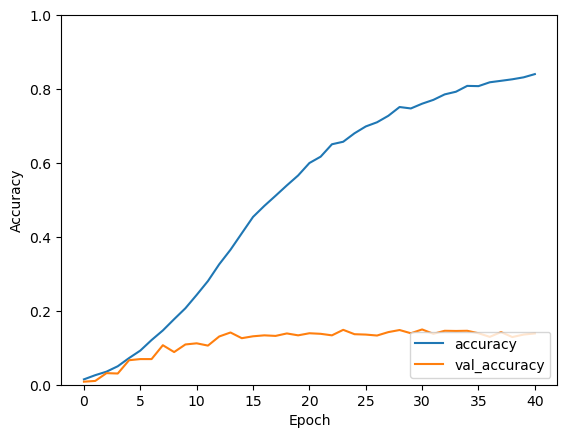

In [20]:
# plot training history
plt.plot(history_basic.history['accuracy'], label='accuracy')
plt.plot(history_basic.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Use transfer learning to improve results and stop overfitting

In [21]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_transfer_learning_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

history_transfer1 = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 4.1015 - accuracy: 0.0830
Epoch 1: val_accuracy improved from -inf to 0.32528, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 17s 56ms/step - loss: 4.1015 - accuracy: 0.0830 - val_loss: 3.2001 - val_accuracy: 0.3253
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 3.2378 - accuracy: 0.2163
Epoch 2: val_accuracy improved from 0.32528 to 0.47842, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 13s 52ms/step - loss: 3.2371 - accuracy: 0.2163 - val_loss: 2.4426 - val_accuracy: 0.4784
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 2.7656 - accuracy: 0.2971
Epoch 3: val_accuracy improved from 0.47842 to 0.53135, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 12s 51ms/step - loss: 2.7660 - accuracy: 0.

In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 43ms/step - loss: 1.4566 - accuracy: 0.6538
Test accuracy: 0.6537829041481018


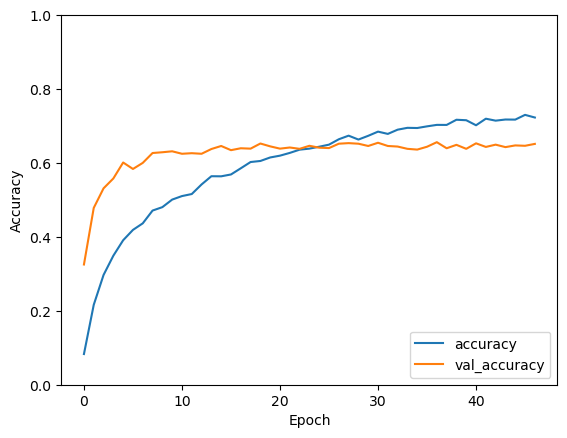

In [24]:
# plot training history
plt.plot(history_transfer1.history['accuracy'], label='accuracy')
plt.plot(history_transfer1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

As we can see above, using the pretrained model has helped stop the overfitting, but our evaluation accuracy is plateauing at just over 60%. Let's improve that by adjusting the layers.

In [25]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# unfreeze the last layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_transfer_learning_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history_transfer2 = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
243/244 [============================>.] - ETA: 0s - loss: 4.9971 - accuracy: 0.0927
Epoch 1: val_accuracy improved from -inf to 0.28366, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 14s 53ms/step - loss: 4.9959 - accuracy: 0.0930 - val_loss: 3.5694 - val_accuracy: 0.2837
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 3.2825 - accuracy: 0.2836
Epoch 2: val_accuracy improved from 0.28366 to 0.44399, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 11s 45ms/step - loss: 3.2826 - accuracy: 0.2836 - val_loss: 2.6870 - val_accuracy: 0.4440
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 2.7475 - accuracy: 0.3866
Epoch 3: val_accuracy improved from 0.44399 to 0.49538, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 11s 45ms/step - loss: 2.7471 - accuracy: 0.

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 43ms/step - loss: 1.4127 - accuracy: 0.7015
Test accuracy: 0.7014802694320679


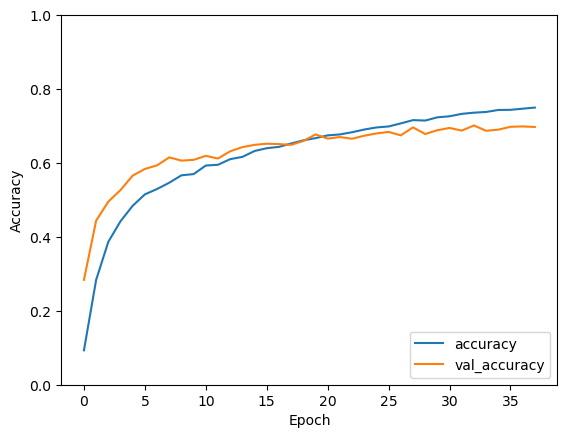

In [28]:
# plot training history
plt.plot(history_transfer2.history['accuracy'], label='accuracy')
plt.plot(history_transfer2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

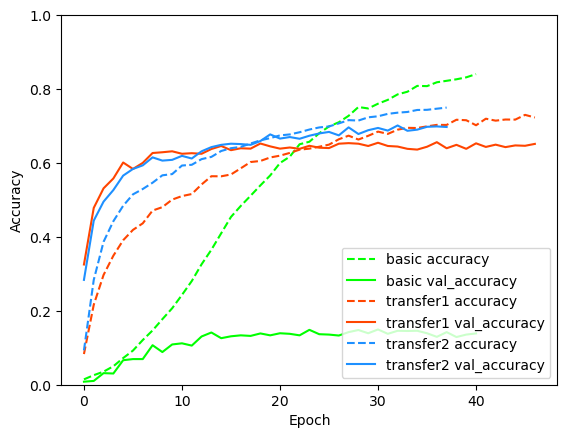

In [ ]:
plt.plot(history_basic.history['accuracy'], label='basic accuracy', color='#00FF00', linestyle='dashed')
plt.plot(history_basic.history['val_accuracy'], label = 'basic val_accuracy', color='#00FF00')
plt.plot(history_transfer1.history['accuracy'], label='transfer1 accuracy', color='#FF4500', linestyle='dashed')
plt.plot(history_transfer1.history['val_accuracy'], label = 'transfer1 val_accuracy', color='#FF4500')
plt.plot(history_transfer2.history['accuracy'], label='transfer2 accuracy', color='#1E90FF', linestyle='dashed')
plt.plot(history_transfer2.history['val_accuracy'], label = 'transfer2 val_accuracy', color='#1E90FF')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [34]:
mem_check()

x_train: 912.00 MB
x_train_scaled: 912.00 MB
x_test: 228.00 MB
x_test_scaled: 228.00 MB
y_train: 0.04 MB
y_test: 0.01 MB
_i: 0.00 MB
_i33: 0.00 MB
_i9: 0.00 MB
PCA: 0.00 MB
Total memory usage: 2280.05 MB


In [35]:
# see if PCA improves the accuracy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_scaled = scaler.transform(x_test.reshape(x_test.shape[0], -1))

In [36]:
mem_check()

x_train: 912.00 MB
x_train_scaled: 912.00 MB
x_test: 228.00 MB
x_test_scaled: 228.00 MB
y_train: 0.04 MB
y_test: 0.01 MB
_iii: 0.00 MB
_i33: 0.00 MB
_i9: 0.00 MB
PCA: 0.00 MB
Total memory usage: 2280.05 MB


In [37]:
del x_train
del x_test
gc.collect()

1798

In [41]:
mem_check()

x_train_scaled: 912.00 MB
x_test_scaled: 228.00 MB
y_train: 0.04 MB
y_test: 0.01 MB
_i33: 0.00 MB
_i9: 0.00 MB
PCA: 0.00 MB
StandardScaler: 0.00 MB
_i25: 0.00 MB
class_counts: 0.00 MB
Total memory usage: 1140.05 MB


In [45]:
from sklearn.decomposition import IncrementalPCA

# Use IncrementalPCA to process data in batches
batch_size = 200

ipca = IncrementalPCA()

# Fit and transform the training data in batches
for i in range(0, x_train_scaled.shape[0], batch_size):
    print(f"Processing batch {i // batch_size + 1}/{x_train_scaled.shape[0] // batch_size}")
    ipca.partial_fit(x_train_scaled[i:i + batch_size])

x_train_pca = ipca.transform(x_train_scaled)
x_test_pca = ipca.transform(x_test_scaled)

print("Original shape:", x_train_scaled.shape)
print("Reduced shape:", x_train_pca.shape)

Processing batch 1/48
Processing batch 2/48
Processing batch 3/48
Processing batch 4/48
Processing batch 5/48
Processing batch 6/48
Processing batch 7/48
Processing batch 8/48
Processing batch 9/48
Processing batch 10/48
Processing batch 11/48
Processing batch 12/48
Processing batch 13/48
Processing batch 14/48
Processing batch 15/48
Processing batch 16/48
Processing batch 17/48
Processing batch 18/48
Processing batch 19/48
Processing batch 20/48
Processing batch 21/48
Processing batch 22/48
Processing batch 23/48
Processing batch 24/48
Processing batch 25/48
Processing batch 26/48
Processing batch 27/48
Processing batch 28/48
Processing batch 29/48
Processing batch 30/48
Processing batch 31/48
Processing batch 32/48
Processing batch 33/48
Processing batch 34/48
Processing batch 35/48
Processing batch 36/48
Processing batch 37/48
Processing batch 38/48
Processing batch 39/48
Processing batch 40/48
Processing batch 41/48
Processing batch 42/48
Processing batch 43/48
Processing batch 44/

MemoryError: Unable to allocate 3.56 GiB for an array with shape (9728, 49152) and data type float64

In [ ]:
mem_check()

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(x_train_pca.shape[1],), include_top=False, weights='imagenet')

base_model.trainable = False

# unfreeze the last layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="transfer_learning_pca.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history_transfer_pca = model.fit(
    x_train_pca, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

TypeError: __init__() missing 1 required positional argument: 'dtype'